In [40]:
!pip install gym==0.15.3

In [41]:
import gym
env = gym.make('CartPole-v1')

In [42]:
print(gym.__version__)


0.15.3


In [43]:
env.action_space

Discrete(2)

In [44]:
env.reset

<bound method TimeLimit.reset of <TimeLimit<CartPoleEnv<CartPole-v1>>>>

In [45]:
env.spec

EnvSpec(CartPole-v1)

In [46]:
env.step

<bound method TimeLimit.step of <TimeLimit<CartPoleEnv<CartPole-v1>>>>

In [47]:
env.render

<bound method Wrapper.render of <TimeLimit<CartPoleEnv<CartPole-v1>>>>

In [48]:
env.observation_space


Box(4,)

In [49]:
import numpy as np

class LogisticPolicy:

    def __init__(self, θ, α, γ):
        # Initialize paramters θ, learning rate α and discount factor γ

        self.θ = θ
        self.α = α
        self.γ = γ

    def logistic(self, y):
        # definition of logistic function

        return 1/(1 + np.exp(-y))

    def probs(self, x):
        # returns probabilities of two actions

        y = x @ self.θ
        prob0 = self.logistic(y)

        return np.array([prob0, 1-prob0])

    def act(self, x):
        # sample an action in proportion to probabilities

        probs = self.probs(x)
        action = np.random.choice([0, 1], p=probs)

        return action, probs[action]

    def grad_log_p(self, x):
        # calculate grad-log-probs

        y = x @ self.θ
        grad_log_p0 = x - x*self.logistic(y)
        grad_log_p1 = - x*self.logistic(y)

        return grad_log_p0, grad_log_p1

    def grad_log_p_dot_rewards(self, grad_log_p, actions, discounted_rewards):
        # dot grads with future rewards for each action in episode

        return grad_log_p.T @ discounted_rewards

    def discount_rewards(self, rewards):
        # calculate temporally adjusted, discounted rewards

        discounted_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        for i in reversed(range(0, len(rewards))):
            cumulative_rewards = cumulative_rewards * self.γ + rewards[i]
            discounted_rewards[i] = cumulative_rewards

        return discounted_rewards

    def update(self, rewards, obs, actions):
        # calculate gradients for each action over all observations
        grad_log_p = np.array([self.grad_log_p(ob)[action] for ob,action in zip(obs,actions)])

        assert grad_log_p.shape == (len(obs), 4)

        # calculate temporaly adjusted, discounted rewards
        discounted_rewards = self.discount_rewards(rewards)

        # gradients times rewards
        dot = self.grad_log_p_dot_rewards(grad_log_p, actions, discounted_rewards)

        # gradient ascent on parameters
        self.θ += self.α*dot

In [54]:
def run_episode(env, policy, render=False):

    observation = env.reset()
    totalreward = 0

    observations = []
    actions = []
    rewards = []
    probs = []

    done = False

    while not done:
        if render:
            env.render()

        observations.append(observation)

        action, prob = policy.act(observation)
        observation, reward, done, info = env.step(action)

        totalreward += reward
        rewards.append(reward)
        actions.append(action)
        probs.append(prob)

    return totalreward, np.array(rewards), np.array(observations), np.array(actions), np.array(probs)

In [55]:
def train(θ, α, γ, Policy, MAX_EPISODES=1000, seed=None, evaluate=False):

    # initialize environment and policy
    env = gym.make('CartPole-v1')
    if seed is not None:
        env.seed(seed)
    episode_rewards = []
    policy = Policy(θ, α, γ)

    # train until MAX_EPISODES
    for i in range(MAX_EPISODES):

        # run a single episode
        total_reward, rewards, observations, actions, probs = run_episode(env, policy)

        # keep track of episode rewards
        episode_rewards.append(total_reward)

        # update policy
        policy.update(rewards, observations, actions)
        print("EP: " + str(i) + " Score: " + str(total_reward) + " ",end="\r", flush=False)

    # evaluation call after training is finished - evaluate last trained policy on 100 episodes
    if evaluate:
        env = Monitor(env, 'pg_cartpole/', video_callable=False, force=True)
        for _ in range(100):
            run_episode(env, policy, render=False)
        env.env.close()

    return episode_rewards, policy

In [52]:
# additional imports for saving and loading a trained policy
from gym.wrappers.monitor import Monitor,load_results

# for reproducibility
GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED)

episode_rewards, policy = train(θ=np.random.rand(4),
                                α=0.002,
                                γ=0.99,
                                Policy=LogisticPolicy,
                                MAX_EPISODES=2000,
                                seed=GLOBAL_SEED,
                                evaluate=True)

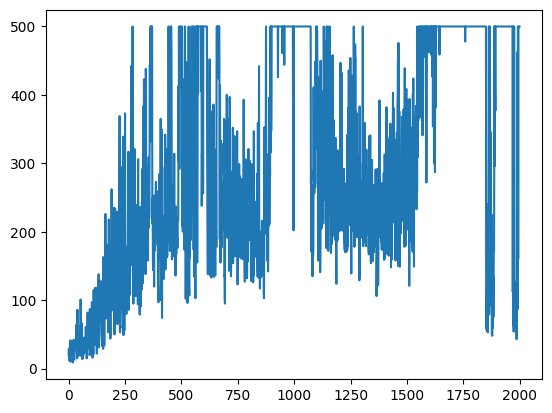

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(episode_rewards);

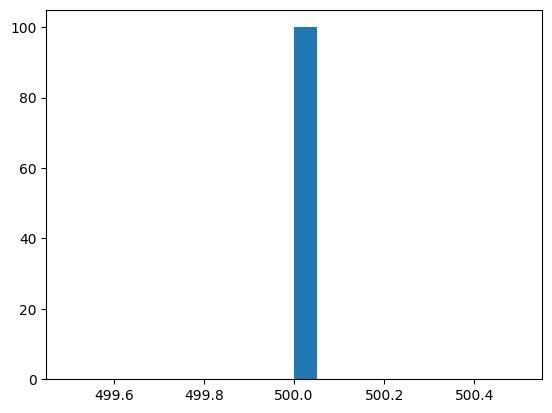

In [57]:
results = load_results('pg_cartpole')
plt.hist(results['episode_rewards'], bins=20);


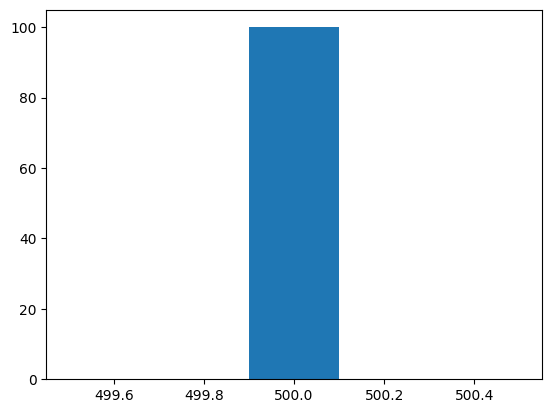

In [58]:
results = load_results('pg_cartpole')
plt.hist(results['episode_rewards'], bins=5);


In [59]:
def discount_rewards(rewards, gamma):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for i in reversed(range(0, len(rewards))):
        cumulative_rewards = cumulative_rewards * gamma + rewards[i]
        discounted_rewards[i] = cumulative_rewards
    return discounted_rewards

In [60]:
%timeit discount_rewards(np.random.rand(100), 0.99)


46.5 µs ± 8.48 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [61]:
import scipy as sp
import scipy.linalg

def toeplitz_discount_rewards(rewards, gamma):
    n = len(rewards)
    c = np.zeros_like(rewards)
    c[0] = 1

    r = np.array([gamma**i for i in range(n)])
    matrix = sp.linalg.toeplitz(c, r)
    discounted_rewards = matrix @ rewards
    return discounted_rewards

In [62]:
%timeit toeplitz_discount_rewards(np.random.rand(100), 0.99)


149 µs ± 58.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [63]:
import scipy.signal

def magic_discount_rewards(rewards, gamma):
    return sp.signal.lfilter([1], [1, float(-gamma)], rewards[::-1], axis=0)[::-1]

In [64]:
%timeit magic_discount_rewards(np.random.rand(100), 0.99)


8.24 µs ± 89.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# Baseline adjustment

In [65]:
import numpy as np
import gym
from gym.wrappers.monitor import Monitor

class LogisticPolicy:

    def __init__(self, θ, α, γ):
        # Initialize parameters θ, learning rate α, and discount factor γ
        self.θ = θ
        self.α = α
        self.γ = γ

    def logistic(self, y):
        # Definition of logistic function
        return 1 / (1 + np.exp(-y))

    def probs(self, x):
        # Returns probabilities of two actions
        y = x @ self.θ
        prob0 = self.logistic(y)
        return np.array([prob0, 1 - prob0])

    def act(self, x):
        # Sample an action in proportion to probabilities
        probs = self.probs(x)
        action = np.random.choice([0, 1], p=probs)
        return action, probs[action]

    def grad_log_p(self, x):
        # Calculate grad-log-probs
        y = x @ self.θ
        grad_log_p0 = x - x * self.logistic(y)
        grad_log_p1 = - x * self.logistic(y)
        return grad_log_p0, grad_log_p1

    def grad_log_p_dot_rewards(self, grad_log_p, actions, discounted_rewards):
        # Dot grads with future rewards for each action in episode
        return grad_log_p.T @ discounted_rewards

    def discount_rewards(self, rewards):
        # Calculate temporally adjusted, discounted rewards
        discounted_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        for i in reversed(range(0, len(rewards))):
            cumulative_rewards = cumulative_rewards * self.γ + rewards[i]
            discounted_rewards[i] = cumulative_rewards
        return discounted_rewards

    def update(self, rewards, obs, actions, baseline=None):
        # Calculate gradients for each action over all observations
        grad_log_p = np.array([self.grad_log_p(ob)[action] for ob, action in zip(obs, actions)])

        assert grad_log_p.shape == (len(obs), 4)

        # Calculate temporally adjusted, discounted rewards
        discounted_rewards = self.discount_rewards(rewards)

        # If baseline is provided, subtract it from the discounted rewards
        if baseline is not None:
            discounted_rewards -= baseline

        # Gradients times rewards
        dot = self.grad_log_p_dot_rewards(grad_log_p, actions, discounted_rewards)

        # Gradient ascent on parameters
        self.θ += self.α * dot

def run_episode(env, policy, render=False):
    observation = env.reset()
    totalreward = 0
    observations = []
    actions = []
    rewards = []

    done = False

    while not done:
        if render:
            env.render()

        observations.append(observation)

        action, _ = policy.act(observation)
        observation, reward, done, _ = env.step(action)

        totalreward += reward
        rewards.append(reward)
        actions.append(action)

    return totalreward, np.array(rewards), np.array(observations), np.array(actions)

def train(θ, α, γ, Policy, MAX_EPISODES=1000, seed=None, evaluate=True):
    # Initialize environment and policy
    env = gym.make('CartPole-v1')
    if seed is not None:
        env.seed(seed)
    episode_rewards = []
    policy = Policy(θ, α, γ)

    # Train until MAX_EPISODES
    for i in range(MAX_EPISODES):
        # Run a single episode
        total_reward, rewards, observations, actions = run_episode(env, policy)
        episode_rewards.append(total_reward)

        # Update policy
        all_rewards = np.hstack(rewards)
        baseline = np.cumsum(policy.discount_rewards(all_rewards)) / len(all_rewards)
        policy.update(rewards, observations, actions, baseline)

    # Evaluation call after training is finished - evaluate the last trained policy on 100 episodes
    if evaluate:
        env = Monitor(env, 'pg_cartpole/', video_callable=False, force=True)
        for _ in range(100):
            run_episode(env, policy, render=False)
        env.env.close()

    return episode_rewards, policy

# For reproducibility
GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED)

episode_rewards, policy = train(θ=np.random.rand(4),
                                α=0.002,
                                γ=0.99,
                                Policy=LogisticPolicy,
                                MAX_EPISODES=2000,
                                seed=GLOBAL_SEED,
                                evaluate=True)


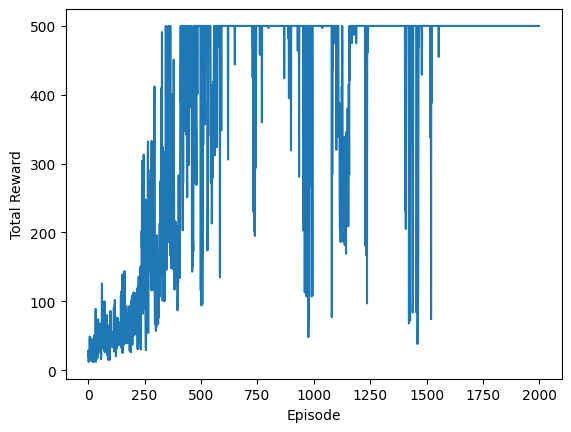

In [67]:
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


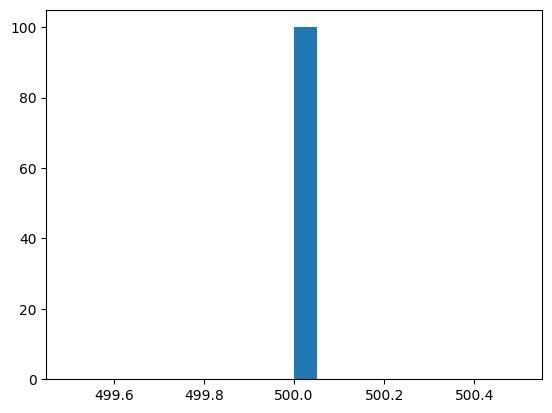

In [68]:
results = load_results('pg_cartpole')
plt.hist(results['episode_rewards'], bins=20);


# Print the score of the episode

In [69]:
import numpy as np
import gym
from gym.wrappers.monitor import Monitor

class LogisticPolicy:

    def __init__(self, θ, α, γ):
        # Initialize parameters θ, learning rate α, and discount factor γ
        self.θ = θ
        self.α = α
        self.γ = γ

    def logistic(self, y):
        # Definition of logistic function
        return 1 / (1 + np.exp(-y))

    def probs(self, x):
        # Returns probabilities of two actions
        y = x @ self.θ
        prob0 = self.logistic(y)
        return np.array([prob0, 1 - prob0])

    def act(self, x):
        # Sample an action in proportion to probabilities
        probs = self.probs(x)
        action = np.random.choice([0, 1], p=probs)
        return action, probs[action]

    def grad_log_p(self, x):
        # Calculate grad-log-probs
        y = x @ self.θ
        grad_log_p0 = x - x * self.logistic(y)
        grad_log_p1 = - x * self. logistic(y)
        return grad_log_p0, grad_log_p1

    def grad_log_p_dot_rewards(self, grad_log_p, actions, discounted_rewards):
        # Dot grads with future rewards for each action in episode
        return grad_log_p.T @ discounted_rewards

    def discount_rewards(self, rewards):
        # Calculate temporally adjusted, discounted rewards
        discounted_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        for i in reversed(range(0, len(rewards))):
            cumulative_rewards = cumulative_rewards * self.γ + rewards[i]
            discounted_rewards[i] = cumulative_rewards
        return discounted_rewards

    def update(self, rewards, obs, actions, baseline=None):
        # Calculate gradients for each action over all observations
        grad_log_p = np.array([self.grad_log_p(ob)[action] for ob, action in zip(obs, actions)])

        assert grad_log_p.shape == (len(obs), 4)

        # Calculate temporally adjusted, discounted rewards
        discounted_rewards = self.discount_rewards(rewards)

        # If baseline is provided, subtract it from the discounted rewards
        if baseline is not None:
            discounted_rewards -= baseline

        # Gradients times rewards
        dot = self.grad_log_p_dot_rewards(grad_log_p, actions, discounted_rewards)

        # Gradient ascent on parameters
        self.θ += self.α * dot


In [70]:
def run_episode(env, policy, render=False):
    observation = env.reset()
    totalreward = 0
    observations = []
    actions = []
    rewards = []

    done = False

    while not done:
        if render:
            env.render()

        observations.append(observation)

        action, _ = policy.act(observation)
        observation, reward, done, _ = env.step(action)

        totalreward += reward
        rewards.append(reward)
        actions.append(action)

    return totalreward, np.array(rewards), np.array(observations), np.array(actions)


In [30]:
def train(θ, α, γ, Policy, MAX_EPISODES=1000, seed=None, evaluate=True):
    # Initialize environment and policy
    env = gym.make('CartPole-v1')
    if seed is not None:
        env.seed(seed)
    episode_rewards = []
    policy = Policy(θ, α, γ)

    # Train until MAX_EPISODES
    for i in range(MAX_EPISODES):
        # Run a single episode
        total_reward, rewards, observations, actions = run_episode(env, policy)
        episode_rewards.append(total_reward)

        # Update policy
        all_rewards = np.hstack(rewards)
        baseline = np.cumsum(policy.discount_rewards(all_rewards)) / len(all_rewards)
        policy.update(rewards, observations, actions, baseline)

        # Print episode score
        print(f"Episode {i + 1}, Score: {total_reward}")

    # Evaluation call after training is finished - evaluate the last trained policy on 100 episodes
    if evaluate:
        env = Monitor(env, 'pg_cartpole/', video_callable=False, force=True)
        for _ in range(100):
            run_episode(env, policy, render=False)
        env.env.close()

    return episode_rewards, policy


In [31]:
# For reproducibility
GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED)

episode_rewards, policy = train(θ=np.random.rand(4),
                                α=0.002,
                                γ=0.99,
                                Policy=LogisticPolicy,
                                MAX_EPISODES=5000,
                                seed=GLOBAL_SEED,
                                evaluate=True)


Episode 1, Score: 20.0
Episode 2, Score: 29.0
Episode 3, Score: 12.0
Episode 4, Score: 19.0
Episode 5, Score: 20.0
Episode 6, Score: 17.0
Episode 7, Score: 43.0
Episode 8, Score: 49.0
Episode 9, Score: 31.0
Episode 10, Score: 20.0
Episode 11, Score: 14.0
Episode 12, Score: 33.0
Episode 13, Score: 23.0
Episode 14, Score: 39.0
Episode 15, Score: 46.0
Episode 16, Score: 16.0
Episode 17, Score: 23.0
Episode 18, Score: 23.0
Episode 19, Score: 43.0
Episode 20, Score: 14.0
Episode 21, Score: 12.0
Episode 22, Score: 28.0
Episode 23, Score: 24.0
Episode 24, Score: 31.0
Episode 25, Score: 12.0
Episode 26, Score: 41.0
Episode 27, Score: 27.0
Episode 28, Score: 51.0
Episode 29, Score: 16.0
Episode 30, Score: 22.0
Episode 31, Score: 30.0
Episode 32, Score: 20.0
Episode 33, Score: 39.0
Episode 34, Score: 89.0
Episode 35, Score: 12.0
Episode 36, Score: 41.0
Episode 37, Score: 36.0
Episode 38, Score: 16.0
Episode 39, Score: 24.0
Episode 40, Score: 27.0
Episode 41, Score: 27.0
Episode 42, Score: 29.0
E

In [32]:
np.var(episode_rewards)

15060.169556960002

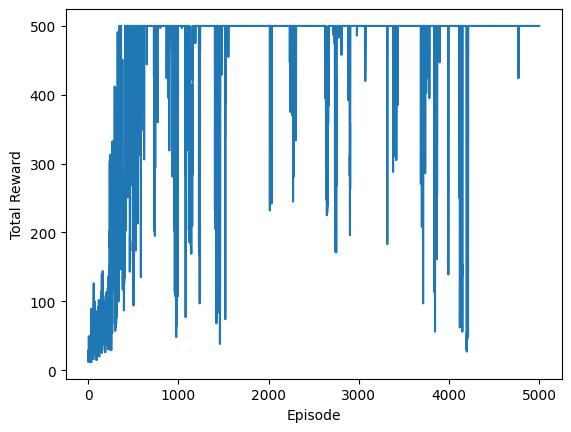

In [33]:
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

In [34]:
env.reset()

array([ 0.03663727,  0.01666166, -0.01986477, -0.02317104])